<a href="https://colab.research.google.com/github/helookscool/Projects/blob/main/Fama_French/LSTM%EC%9C%BC%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%9C_Fama_French_Three_Factor_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 선형회귀분석 파트 

In [ ]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model selection
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error
# for classification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Deep learning tool
#from keras.models import Sequential, Model, load_model
#from keras.layers import Input, Dense, Activation, Flatten, Dropout
#from keras.layers import SimpleRNN, LSTM, GRU

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Activation, Flatten, Dropout, Input
from tensorflow.keras.losses import Huber #손실함수
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as smf
import tensorflow as tf

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/projects/프로젝트3/파마프렌치/')

In [ ]:
df = pd.read_csv('fama french 3 factor in korea daily return (only kospi)-수정.csv')
df

,Unnamed: 0,Mkt-Rf,SMB,HML
0,2011-10-20,-0.03,0.01,0.01
1,2011-10-21,0.02,0.00,-0.00
2,2011-10-24,0.03,-0.01,-0.00
3,2011-10-25,-0.01,0.00,0.01
4,2011-10-26,0.00,0.00,0.00
...,...,...,...,...
2053,2020-02-24,-0.04,0.00,0.00
2054,2020-02-25,0.01,0.01,-0.02
2055,2020-02-26,-0.01,0.00,0.00
2056,2020-02-27,-0.01,-0.01,0.00


In [ ]:
df.rename(columns={'Unnamed: 0':'DateTime'}, inplace= True)

if 'DateTime' in df.columns:
    df['DateTime'] = pd.to_datetime(df['DateTime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  2058 non-null   datetime64[ns]
 1   Mkt-Rf    2058 non-null   float64       
 2   SMB       2058 non-null   float64       
 3   HML       2058 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 64.4 KB


In [ ]:
# set index as datetime column
if df.index.dtype == 'int64':
    df.set_index('DateTime', inplace=True)
df

,Mkt-Rf,SMB,HML
DateTime,,,
2011-10-20,-0.03,0.01,0.01
2011-10-21,0.02,0.00,-0.00
2011-10-24,0.03,-0.01,-0.00
2011-10-25,-0.01,0.00,0.01
2011-10-26,0.00,0.00,0.00
...,...,...,...
2020-02-24,-0.04,0.00,0.00
2020-02-25,0.01,0.01,-0.02
2020-02-26,-0.01,0.00,0.00


In [ ]:
#주식의 주식률, 
df_M = pd.read_csv('KBSTAR 200 수정.csv', encoding='cp949')
df_M.head()

,일자,종가,대비,등락률,순자산가치(NAV),시가,고가,저가,거래량,거래대금,시가총액,순자산총액,상장좌수,기초지수_지수명,기초지수_종가,기초지수_대비,기초지수_등락률,국고채10년(평균)
0,2011-10-20,23495,710,-2.93,"23,552.62",24150,24400,23495,517112,"12,256,704,245.00","106,000,000,000.00","106,000,000,000.00",4500000,코스피 200,235.57,nan,nan,0.04
1,2011-10-21,23850,355,1.51,"23,997.35",23695,23965,23515,56310,"1,329,819,265.00","107,000,000,000.00","108,000,000,000.00",4500000,코스피 200,240.02,4.45,1.89,0.04
2,2011-10-24,24765,915,3.84,"24,817.08",24205,24765,24180,979,"24,018,415.00","111,000,000,000.00","112,000,000,000.00",4500000,코스피 200,248.21,8.19,3.41,0.04
3,2011-10-25,24605,160,-0.65,"24,715.20",24805,24805,24565,15047,"371,649,505.00","111,000,000,000.00","111,000,000,000.00",4500000,코스피 200,247.20,1.01,-0.41,0.04
4,2011-10-26,24655,50,0.20,"24,751.15",24400,24655,24325,55120,"1,351,031,520.00","111,000,000,000.00","111,000,000,000.00",4500000,코스피 200,247.56,0.36,0.15,0.04


In [ ]:
df_M.rename(columns={'일자':'DateTime'}, inplace= True)

if 'DateTime' in df_M.columns:
    df_M['DateTime'] = pd.to_datetime(df_M['DateTime'])
df_M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DateTime    2058 non-null   datetime64[ns]
 1   종가          2058 non-null   int64         
 2   대비          2058 non-null   int64         
 3   등락률         2058 non-null   float64       
 4   순자산가치(NAV)  2058 non-null   float64       
 5   시가          2058 non-null   int64         
 6   고가          2058 non-null   int64         
 7   저가          2058 non-null   int64         
 8   거래량         2058 non-null   int64         
 9   거래대금        2058 non-null   float64       
 10  시가총액        2058 non-null   float64       
 11  순자산총액       2058 non-null   float64       
 12  상장좌수        2058 non-null   int64         
 13  기초지수_지수명    2058 non-null   object        
 14  기초지수_종가     2058 non-null   float64       
 15  기초지수_대비     2057 non-null   float64       
 16  기초지수_등락률    2057 non-nul

In [ ]:
if df_M.index.dtype == 'int64':
    df_M.set_index('DateTime', inplace=True)
df_M

,종가,대비,등락률,순자산가치(NAV),시가,고가,저가,거래량,거래대금,시가총액,순자산총액,상장좌수,기초지수_지수명,기초지수_종가,기초지수_대비,기초지수_등락률,국고채10년(평균)
DateTime,,,,,,,,,,,,,,,,,
2011-10-20,23495,710,-2.93,"23,552.62",24150,24400,23495,517112,"12,256,704,245.00","106,000,000,000.00","106,000,000,000.00",4500000,코스피 200,235.57,nan,nan,0.04
2011-10-21,23850,355,1.51,"23,997.35",23695,23965,23515,56310,"1,329,819,265.00","107,000,000,000.00","108,000,000,000.00",4500000,코스피 200,240.02,4.45,1.89,0.04
2011-10-24,24765,915,3.84,"24,817.08",24205,24765,24180,979,"24,018,415.00","111,000,000,000.00","112,000,000,000.00",4500000,코스피 200,248.21,8.19,3.41,0.04
2011-10-25,24605,160,-0.65,"24,715.20",24805,24805,24565,15047,"371,649,505.00","111,000,000,000.00","111,000,000,000.00",4500000,코스피 200,247.20,1.01,-0.41,0.04
2011-10-26,24655,50,0.20,"24,751.15",24400,24655,24325,55120,"1,351,031,520.00","111,000,000,000.00","111,000,000,000.00",4500000,코스피 200,247.56,0.36,0.15,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-24,28475,1120,-3.78,"28,503.67",28975,29005,28460,945660,"27,151,737,685.00","1,270,000,000,000.00","1,270,000,000,000.00",44600000,코스피 200,281.02,11.40,-3.90,0.02
2020-02-25,28785,310,1.09,"28,828.29",28445,28800,28350,554037,"15,843,400,665.00","1,280,000,000,000.00","1,280,000,000,000.00",44400000,코스피 200,284.24,3.22,1.15,0.02
2020-02-26,28380,405,-1.41,"28,390.70",28300,28540,28170,511016,"14,483,624,255.00","1,260,000,000,000.00","1,260,000,000,000.00",44300000,코스피 200,279.94,4.30,-1.51,0.02


In [ ]:
df_m = pd.DataFrame(df_M['종가'].pct_change()[1:])
df_m

,종가
DateTime,
2011-10-21,0.02
2011-10-24,0.04
2011-10-25,-0.01
2011-10-26,0.00
2011-10-27,0.02
...,...
2020-02-24,-0.04
2020-02-25,0.01
2020-02-26,-0.01


In [ ]:
regress_data=df.merge( df_m, left_index=True, right_index=True)
regress_data

,Mkt-Rf,SMB,HML,종가
DateTime,,,,
2011-10-21,0.02,0.00,-0.00,0.02
2011-10-24,0.03,-0.01,-0.00,0.04
2011-10-25,-0.01,0.00,0.01,-0.01
2011-10-26,0.00,0.00,0.00,0.00
2011-10-27,0.01,-0.00,-0.01,0.02
...,...,...,...,...
2020-02-24,-0.04,0.00,0.00,-0.04
2020-02-25,0.01,0.01,-0.02,0.01
2020-02-26,-0.01,0.00,0.00,-0.01


In [ ]:
df_rf = df_M['국고채10년(평균)']
df_rf = pd.DataFrame(df_rf)
df_rf

,국고채10년(평균)
DateTime,
2011-10-20,0.04
2011-10-21,0.04
2011-10-24,0.04
2011-10-25,0.04
2011-10-26,0.04
...,...
2020-02-24,0.02
2020-02-25,0.02
2020-02-26,0.02


In [ ]:
regress_data = regress_data.merge( df_rf,left_index=True, right_index=True)
regress_data

,Mkt-Rf,SMB,HML,종가,국고채10년(평균)
DateTime,,,,,
2011-10-21,0.02,0.00,-0.00,0.02,0.04
2011-10-24,0.03,-0.01,-0.00,0.04,0.04
2011-10-25,-0.01,0.00,0.01,-0.01,0.04
2011-10-26,0.00,0.00,0.00,0.00,0.04
2011-10-27,0.01,-0.00,-0.01,0.02,0.04
...,...,...,...,...,...
2020-02-24,-0.04,0.00,0.00,-0.04,0.02
2020-02-25,0.01,0.01,-0.02,0.01,0.02
2020-02-26,-0.01,0.00,0.00,-0.01,0.02


In [ ]:
#종속변수인 초과수익률 구하는거임
regress_data['port_excess'] = regress_data['종가'] - regress_data['국고채10년(평균)']
print(regress_data.tail())

            Mkt-Rf   SMB   HML    종가  국고채10년(평균)  port_excess
DateTime                                                     
2020-02-24   -0.04  0.00  0.00 -0.04        0.02        -0.06
2020-02-25    0.01  0.01 -0.02  0.01        0.02        -0.01
2020-02-26   -0.01  0.00  0.00 -0.01        0.02        -0.03
2020-02-27   -0.01 -0.01  0.00 -0.01        0.02        -0.03
2020-02-28   -0.03 -0.00 -0.00 -0.03        0.02        -0.05


In [ ]:
regress_data.rename(columns={"Mkt-Rf":"mkt_excess"}, inplace=True)

In [ ]:
regress_data

,mkt_excess,SMB,HML,종가,국고채10년(평균),port_excess
DateTime,,,,,,
2011-10-21,0.02,0.00,-0.00,0.02,0.04,-0.03
2011-10-24,0.03,-0.01,-0.00,0.04,0.04,-0.00
2011-10-25,-0.01,0.00,0.01,-0.01,0.04,-0.05
2011-10-26,0.00,0.00,0.00,0.00,0.04,-0.04
2011-10-27,0.01,-0.00,-0.01,0.02,0.04,-0.03
...,...,...,...,...,...,...
2020-02-24,-0.04,0.00,0.00,-0.04,0.02,-0.06
2020-02-25,0.01,0.01,-0.02,0.01,0.02,-0.01
2020-02-26,-0.01,0.00,0.00,-0.01,0.02,-0.03


In [ ]:
model = smf.formula.ols(formula = "port_excess ~ mkt_excess + SMB + HML", data = regress_data).fit()

In [ ]:
print(model.params)

Intercept    -0.03
mkt_excess    0.96
SMB          -0.15
HML          -0.08
dtype: float64


In [ ]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            port_excess   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     673.7
Date:                Sun, 31 Oct 2021   Prob (F-statistic):          7.54e-305
Time:                        23:48:05   Log-Likelihood:                 6873.9
No. Observations:                2057   AIC:                        -1.374e+04
Df Residuals:                    2053   BIC:                        -1.372e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0288      0.000   -152.133      0.0

In [ ]:
# sns.lmplot(data=regress_data, x='RowNum', y='Error')

# LSTM파트

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [ ]:
# Parameters
criteria = '2018-01-04'
scaler = StandardScaler()
sequence = 12
batch_size = 12
epoch = 300
verbose = 1
dropout_ratio = 0.7

In [ ]:
# feature
X_columns = ["mkt_excess", "SMB", "HML"]
# target
Y_columns = ["port_excess"]

In [ ]:
## Train & Test Split 
train = regress_data.loc[regress_data.index < criteria,:]
test = regress_data.loc[regress_data.index >= criteria,:]
print('Train_size:', train.shape, 'Test_size:', test.shape)

Y_train = train[Y_columns]
X_train = train[X_columns]
Y_test = test[Y_columns]
X_test = test[X_columns]
print('Train_size:', train.shape, 'Test_size:', test.shape)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

Train_size: (1529, 6) Test_size: (528, 6)
Train_size: (1529, 6) Test_size: (528, 6)
X_train: (1529, 3) Y_train: (1529, 1)
X_test: (528, 3) Y_test: (528, 1)


In [ ]:
## Scaling
X_train_scaled = scaler.fit_transform(X_train)
Y_train_scaled = scaler.fit_transform(Y_train)
X_test_scaled = scaler.transform(X_test)
Y_test_scaled = scaler.transform(Y_test)

In [ ]:
## X / Y Split
X_train, Y_train = [], []
for index in range(len(X_train_scaled) - sequence):
    X_train.append(np.array(X_train_scaled[index: index + sequence]))
    Y_train.append(np.ravel(Y_train_scaled[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = [], []
for index in range(len(X_test_scaled) - sequence):
    X_test.append(np.array(X_test_scaled[index: index + sequence]))
    Y_test.append(np.ravel(Y_test_scaled[index + sequence:index + sequence + 1]))  
X_test, Y_test = np.array(X_test), np.array(Y_test) 


In [ ]:
## Retype and Reshape
X_train = X_train.reshape(X_train.shape[0], sequence, -1)
X_test = X_test.reshape(X_test.shape[0], sequence, -1)
print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

X_train: (1517, 12, 3) Y_train: (1517, 1)
X_test: (516, 12, 3) Y_test: (516, 1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 12, 128)           67584     
_________________________________________________________________
dropout (Dropout)            (None, 12, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 256)           394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 128)           197120    
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                4

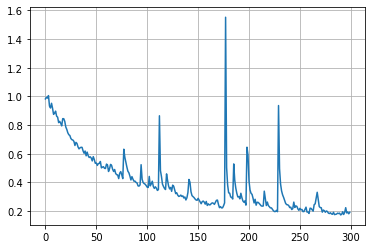

In [ ]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit = model.fit(X_train, Y_train, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit.history))
plt.grid(True)
plt.show()


In [ ]:
# prediction
Y_train_pred = model.predict(X_train) 
Y_test_pred = model.predict(X_test)

In [ ]:
### Evaluation Function
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)

In [ ]:
### Evaluation of train/test pairs tr은 트레이닝이고 te는 test임.
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te

17/17 [==============================] - 0s 15ms/step - loss: 0.0000e+00


,MAE,MSE,MAPE
Train,0.00,0.00,-9.60
Test,0.01,0.00,-45.24


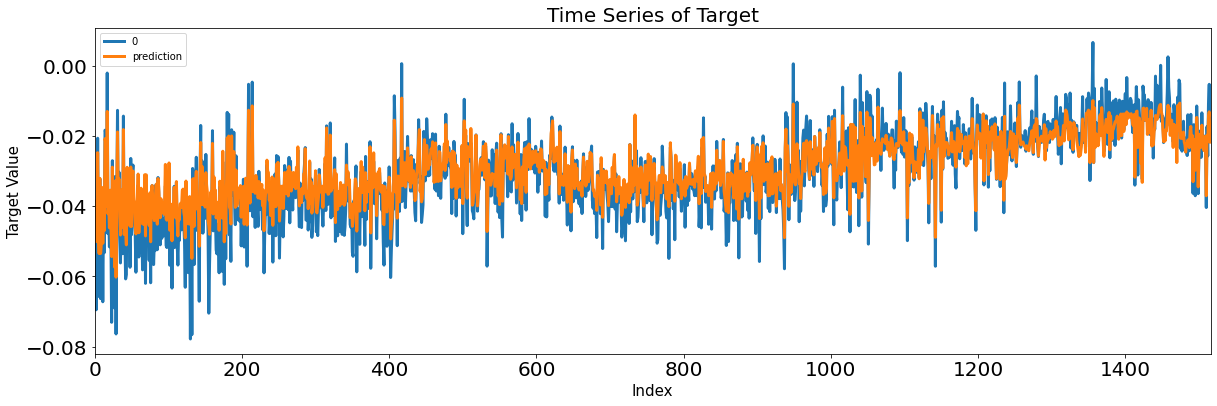

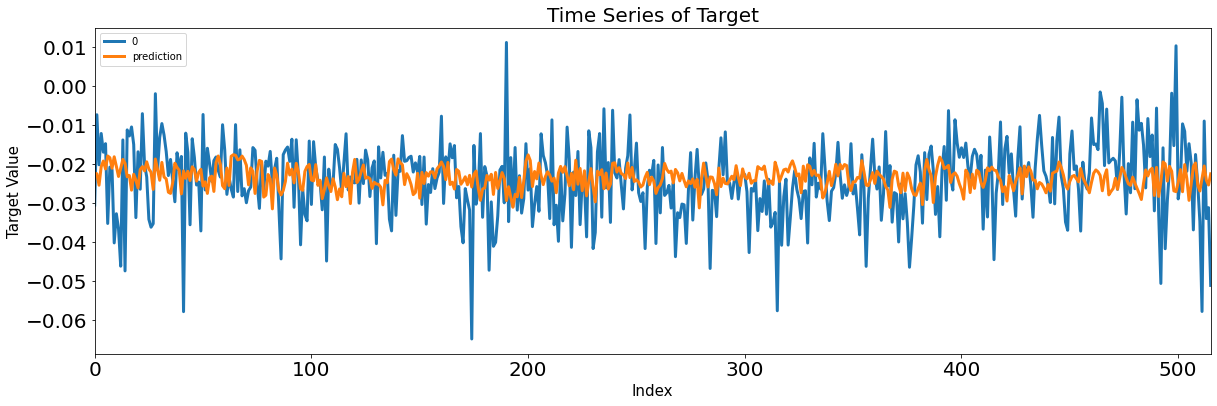

In [ ]:
# evaluation
result = model.evaluate(X_test, Y_test_pred)

if scaler != []: 
    Y_train = scaler.inverse_transform(Y_train)
    Y_train_pred = scaler.inverse_transform(Y_train_pred)
    Y_test = scaler.inverse_transform(Y_test)
    Y_test_pred = scaler.inverse_transform(Y_test_pred)

Score_LSTM, Residual_tr, Residual_te = evaluation_trte(pd.DataFrame(Y_train), Y_train_pred.flatten(), 
                                                      pd.DataFrame(Y_test), Y_test_pred.flatten(), graph_on=True)
display(Score_LSTM)

# error analysis
#error_analysis(Residual_te, ['Error'], X_test_feR.reset_index().iloc[:,1:].loc[Residual_te.index], graph_on=True)